In [51]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# find root directory and add to path
root_index = os.getcwd().rfind('notebooks')
root_directory = os.path.dirname(os.getcwd()[:root_index])
sys.path.append(root_directory)

from MotorNet.plants import CompliantTendonArm
from MotorNet.utils.plotor import plot_pos_over_time
from MotorNet.nets.losses import empty_loss, position_loss, activation_squared_loss
from MotorNet.nets.layers import GRUController
from MotorNet.nets.callbacks import BatchLogger, TrainingPlotter

%load_ext autoreload
%autoreload 2

# tf.debugging.enable_check_numerics()
print('tensorflow version: ' + tf.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensorflow version: 2.3.0


0.9591234772558495


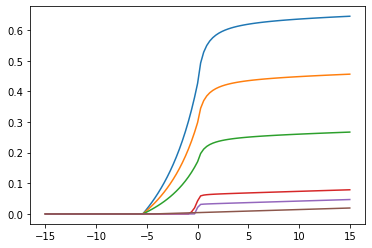

In [52]:

norm_muscle_len = 0.5
new_activation = 1.
rho = 1.37e-4 * 5.27e4 * (2.9 - 1) * norm_muscle_len / (2.9 - norm_muscle_len)
cte = (rho * new_activation) ** 3
q = (5e-3 + cte) / (1 + cte)
print(q)
q=np.array([1., 0.7, 0.4, 0.1, 0.05, 0.01]).astype('float32').reshape((1,-1))
a = 1 / (0.66 ** 2)
q_crit = 0.3
f_iso_n = tf.maximum(- a * norm_muscle_len ** 2 + 2 * a * norm_muscle_len - a + 1, 0.)


a_rel_st = tf.where(norm_muscle_len > 1., .41 * f_iso_n, .41)
b_rel_st = tf.where(q < q_crit, 5.2 * (1 - .9 * ((q - q_crit) / (5e-3 - q_crit))) ** 2, 5.2)

f_asymp = 1.5  # * f_iso_n * q
slopfac = 2.
sloplin = 1000.

dvdf_isom_con = b_rel_st / (q * (f_iso_n + a_rel_st)) # slope in the isometric point at wrt concentric part
dfdvcon0 = 1. / dvdf_isom_con
s_as = 1. / sloplin

p1 = -(f_iso_n * q * (f_asymp - 1)) / (s_as - dfdvcon0 * slopfac)
p2 = ((f_iso_n * q * (f_asymp - 1)) ** 2) / (s_as - dfdvcon0 * slopfac)
p3 =  -f_asymp * f_iso_n * q
p4 =  -s_as

v = tf.reshape(tf.linspace(-15.,15.,101), (-1, 1))
F = tf.where(
    v<0,
    (v * q * a_rel_st + f_iso_n * q * b_rel_st) / (b_rel_st - v),
    (-p1*p3 - p1*p4*v + p2 - p3*v - p4*v**2)/(p1 + v)
)
F = tf.where(f_iso_n * q > 0.01, F, v / sloplin + f_iso_n * q)

F = tf.maximum(F, 0.)
plt.plot(v, F)
plt.show()



0.009857668


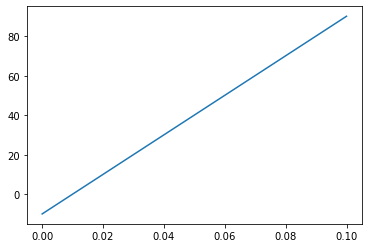

In [53]:
sloplin = 1000.
s_as = 1 / sloplin
min_iso_force = 1.
max_iso_force = 1000.
f_iso_n_den = .66 ** 2
b_rel_st_den = 5e-3 - 0.3
lin_thres = 0.01

active_force = np.linspace(0., 0.1, 101).astype('float32').reshape((-1,1))
F = active_force
norm_muscle_len = 0.53
q = .02


f_iso_n = 1 + (- norm_muscle_len ** 2 + 2 * norm_muscle_len - 1) / f_iso_n_den
f_iso_n = tf.maximum(f_iso_n, min_iso_force / max_iso_force)

q_f_iso_n = f_iso_n * q
not_use_lin = q_f_iso_n >= lin_thres
print(q_f_iso_n.numpy())

new_muscle_vel_lin = sloplin * (active_force - q_f_iso_n)
transition_line = sloplin * (active_force - lin_thres)

# a_rel_st = tf.where(norm_muscle_len > 1., .41 * f_iso_n, .41)
# b_rel_st = tf.where(q < 0.3, 5.2 * (1 - .9 * ((q - 0.3) / b_rel_st_den)) ** 2, 5.2)
# (active_force - f_iso_n * b_rel_st) / a_rel_st
# (active_force - f_iso_n * b_rel_st) / a_rel_st


a_rel_st = tf.where(norm_muscle_len > 1., .41 * f_iso_n, .41)
b_rel_st = tf.where(q < 0.3, 5.2 * (1 - .9 * ((q - 0.3) / b_rel_st_den)) ** 2, 5.2)

dvdf_isom_con = b_rel_st / (q * (f_iso_n + a_rel_st))  # slope in the isometric point at wrt concentric part
dfdvcon0 = 1. / dvdf_isom_con

p1 = -(q_f_iso_n * 0.5) / (s_as - dfdvcon0 * 2)
p3 = - 1.5 * q_f_iso_n
p4 = - s_as
p2_containing_term = (4 * ((q_f_iso_n * 0.5) ** 2) * p4) / (s_as - dfdvcon0 * 2)

sqrt_term = active_force ** 2 - 2 * active_force * p1 * p4 + \
    2 * active_force * p3 + p1 ** 2 * p4 ** 2 - 2 * p1 * p3 * p4 + p2_containing_term + p3 ** 2
# cond = tf.where(tf.logical_and(tf.logical_and(sqrt_term < 0, active_force >= q_f_iso_n), not_use_lin), -1, 1)
cond = tf.where(tf.logical_and(sqrt_term < 0, active_force >= q_f_iso_n), -1, 1)
tf.debugging.assert_non_negative(cond, message='root that should be used is negative.')
sqrt_term = tf.maximum(sqrt_term, 0.)

new_muscle_vel_nom = tf.where(
    active_force < q_f_iso_n,
    b_rel_st * (active_force - q_f_iso_n),
    -active_force + p1 * s_as - p3 - tf.sqrt(sqrt_term)
)
new_muscle_vel_den = tf.where(
    active_force < q_f_iso_n,
    active_force + q * a_rel_st,
    -2 * s_as,
)

v = tf.minimum(new_muscle_vel_nom / new_muscle_vel_den, transition_line)
# v = new_muscle_vel_nom / new_muscle_vel_den
v = tf.where(not_use_lin, v, new_muscle_vel_lin)

plt.plot(F, v)
plt.show()


simulation duration: 11.952999999979511 sec


Text(0.5, 1.0, 'drift from passive muscle forces alone')

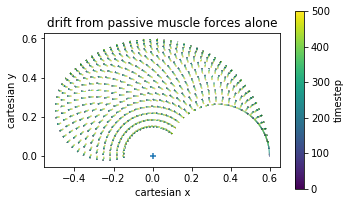

In [60]:
arm = CompliantTendonArm(timestep=0.0001, min_activation=0.01)

sho, elb = np.meshgrid(
    np.linspace(arm.pos_lower_bound[0], arm.pos_upper_bound[0], 21).astype('float32'),
    np.linspace(arm.pos_lower_bound[1], arm.pos_upper_bound[1], 21).astype('float32'))
z = tf.zeros_like(sho.reshape(-1))

ex = tf.ones((sho.size, arm.n_muscles)) * [0, 1, 0, 0, 0, 0]
state0 = arm.get_initial_state(joint_state=tf.stack([sho.reshape(-1), elb.reshape(-1), z, z], axis=1))

j_results = state0[0][:, tf.newaxis, :]
c_results = state0[1][:, tf.newaxis, :]
m_results = state0[2][:, tf.newaxis, :, :]
states = state0

start = time.monotonic()
# 200 ms simulation to assess drift
for _ in range(int(0.05 / arm.dt)):
    states = arm(ex, states[0], states[-2], states[-1])
    j_results = tf.concat([j_results, states[0][:, tf.newaxis, :]], axis=1)
    c_results = tf.concat([c_results, states[1][:, tf.newaxis, :]], axis=1)
    m_results = tf.concat([m_results, states[-2][:, tf.newaxis, :, :]], axis=1)
print('simulation duration: ' + str(time.monotonic() - start) + ' sec')

plt.figure(figsize=(5, 3)).set_tight_layout(True)
plot_pos_over_time(cart_results=c_results)
plt.title('drift from passive muscle forces alone')


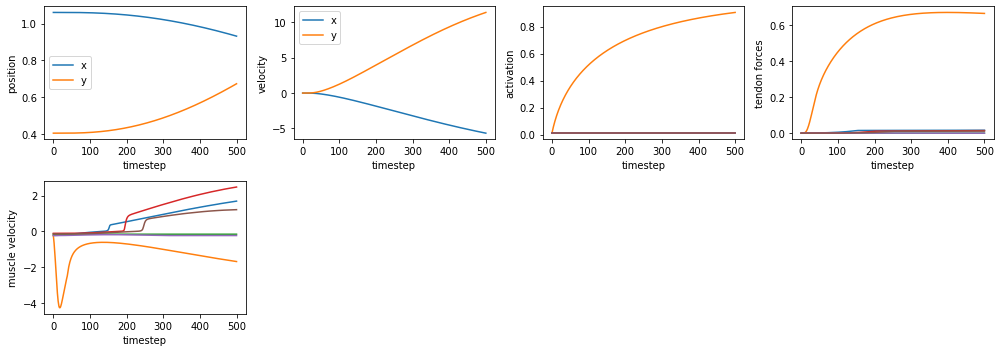

In [61]:
trial = 72
plt.figure(figsize=(14, 5)).set_tight_layout(True)

plt.subplot(241)
plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='x')
plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='y')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('position')

plt.subplot(242)
plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='x')
plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='y')
plt.legend()
plt.xlabel('timestep')
plt.ylabel('velocity')

plt.subplot(243)
plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
plt.xlabel('timestep')
plt.ylabel('activation')

plt.subplot(244)
x= m_results[trial, :, 5, :]
plt.plot(x.numpy().squeeze())
plt.xlabel('timestep')
plt.ylabel('tendon forces')

plt.subplot(245)
x= m_results[trial, :, 2, :]
plt.plot(x.numpy().squeeze())
plt.xlabel('timestep')
plt.ylabel('muscle velocity')

plt.show()
# new_muscle_state = tf.concat([new_activation, new_muscle_len, new_muscle_vel, moment_arm, flpe, flse, active_force], axis=1)

In [65]:
class MultistepController(GRUController):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shapes):
        for k in range(self.n_hidden_layers):
            layer = tf.keras.layers.GRUCell(units=self.n_units[k],
                            activation=self.activation,
                            name='hidden_layer_' + str(k),
                            kernel_regularizer=self.kernel_regularizer,
                            activity_regularizer=self.activity_regularizer)
            self.layers.append(layer)
        output_layer = tf.keras.layers.Dense(units=self.plant.input_dim,
                             activation='sigmoid',
                             name='output_layer',
                             bias_initializer=tf.initializers.Constant(value=0),
                             kernel_initializer=tf.initializers.random_normal(stddev=10 ** -1))
        self.layers.append(output_layer)
        self.built = True


In [67]:
for _ in range(100):
    arm = CompliantTendonArm(timestep=0.0001, min_activation=0.01)
    rnn = MultistepController(plant=arm, n_units=50, kernel_regularizer=0.*10**-6, name='cell', n_ministeps=10)

    # declare inputs
    targets = Input((None, arm.state_dim,), name='target')
    state0 = [Input((arm.state_dim, ), name='joint0'),
              Input((arm.state_dim, ), name='cartesian0'),
              Input((arm.muscle_state_dim, arm.n_muscles, ), name='muscle0'),
              Input((arm.geometry_state_dim, arm.n_muscles, ), name='geometry0'),
              Input((arm.n_muscles * 2, arm.proprioceptive_delay, ), name='proprio_feedback0'),
              Input((arm.space_dim, arm.visual_delay, ), name='visual_feedback0')]
    state0.extend([Input((n, ), name='gru' + str(k) + '_hidden0') for k, n in enumerate(rnn.n_units)])


    # wrap cell in an RNN layer
    states_out = tf.keras.layers.RNN(cell=rnn, return_sequences=True, name='RNN')(targets, initial_state=state0)
    control_rnn = Model(inputs=[targets, state0], outputs=states_out, name='controller')


    # link outputs to their loss
    losses = {name: empty_loss() for name in states_out.keys()}
    loss_weights = {name: 0. for name in states_out.keys()}
    losses['cartesian position'] = position_loss()
    losses['muscle state'] = activation_squared_loss()
    loss_weights['cartesian position'] = 1
    loss_weights['muscle state'] = 0


    # and compile
    control_rnn.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=losses, loss_weights=loss_weights)
    batchlog_callback = BatchLogger()
    # control_rnn.summary()
    # losses

    #%

    # name = '50gru_1e-3dt_10ministeps'
    # control_rnn.load_weights(os.getcwd() + '/saved_models/compliant_tendon/' + name)
    batch_size = 64
    dataset_size = 150 * batch_size
    # n_t = int(0.5 / (arm.dt * cell.n_ministeps))
    n_t = int(0.5 / (arm.dt * rnn.n_ministeps))
    # n_t

    #%

    # tf.debugging.disable_check_numerics()
    with tf.device('/cpu:0'):
        for _ in range(1):
            init_states = rnn.get_initial_state(batch_size=dataset_size)
            # inputs=cell.plant.draw_fixed_states(position=np.deg2rad([45., 90.]), batch_size=dataset_size),
            goal_states = arm.draw_random_uniform_states(batch_size=dataset_size)
            target = arm.state2target(state=arm.joint2cartesian(goal_states), n_timesteps=n_t)
            control_rnn.fit([target, init_states], target, epochs=1, batch_size=batch_size, callbacks=[TrainingPlotter()], verbose=1, shuffle=False)



NameError: name 'TrainingPlotter' is not defined

In [ ]:
if 'loss' in batchlog_callback.history:
    plt.plot(batchlog_callback.history['loss'])
    plt.xlabel('batch')
    plt.ylabel('loss')
    # plt.semilogy()
    plt.show()


In [ ]:
init_states_sample = cell.get_initial_state(batch_size=50)
# inputs=cell.plant.draw_fixed_states(position=np.deg2rad([45., 90.]), batch_size=50),
goal_states = arm.draw_random_uniform_states(batch_size=50)
target_sample = arm.state2target(state=arm.joint2cartesian(goal_states), n_timesteps=n_t)

results = control_rnn([target_sample, init_states_sample], training=False)

#%
j_results = results['joint position']
c_results = results['cartesian position']
m_results = results['muscle state']

plt.figure(figsize=(16, 4)).set_tight_layout(True)
plt.subplot(121)
plot_pos_over_time(cart_results=c_results)
plt.scatter(target_sample[:, 0, 0], target_sample[:, 0, 1])

plt.subplot(122)
plot_pos_over_time(cart_results=c_results - target_sample)
plt.xlabel('distance to target (x)')
plt.ylabel('distance to target (y)')
plt.show()


In [ ]:
trial += 1
plt.figure(figsize=(18, 2.5)).set_tight_layout(True)

plt.subplot(161)
plt.plot(j_results[trial, :, 0].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 1].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle (rad)')

plt.subplot(162)
plt.plot(j_results[trial, :, 2].numpy().squeeze(), label='sho')
plt.plot(j_results[trial, :, 3].numpy().squeeze(), label='elb')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('angle velocity (rad/sec)')

plt.subplot(163)
plt.plot(m_results[trial, :, 0, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('activation (a.u.)')

plt.subplot(164)
plt.plot(m_results[trial, :, 2, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('muscle velocity (m/sec)')
# plt.xlim([100, 150])

plt.subplot(165)
plt.plot(m_results[trial, :, 4, :].numpy().squeeze())
plt.xlabel('time (ms)')
plt.ylabel('tendon force (normalized)')
# plt.xlim([100, 130])

plt.show()


In [ ]:
if len(batchlog_callback.weights_log) > 0:
    w0 = batchlog_callback.weights_log[0]
    w1 = batchlog_callback.weights_log[-4]

    fig, axs = plt.subplots(nrows=2, ncols=len(w0), sharex='col')
    fig.set_tight_layout(tight=True)
    fig.set_size_inches((15, 6))

    for n in range(len(w0)):
        weights_ini = w0[n].numpy()
        weights_fin = w1[n].numpy()

        if len(weights_ini.shape) < 10:
            axs[0,n].hist(weights_ini.flatten())
            axs[1,n].hist(weights_fin.flatten())
        else:
            axs[0,n].imshow(weights_ini, interpolation='none')
            axs[1,n].imshow(weights_fin, interpolation='none')

    plt.show()



In [ ]:
### To apply a set of weights from a previous iteration weight set w1
# control_rnn.get_layer('RNN').set_weights([w.numpy() for w in w1])

### save model
# name = '50gru_1e-3dt_10ministeps'
# control_rnn.save_weights(os.getcwd() + '/saved_models/compliant_tendon/' + name)